# Chapter 44 - Model to Predict the Critical Temperature of Superconductors
## Building Machine Learning and Deep Learning Models on Google Cloud Platform
### Ekaba Bisong

## Connect to GCP

In [9]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [10]:
# configure GCP project
project_id = 'ekabasandbox'
!gcloud config set project {project_id}

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud alpha survey



## Stage Raw Data in GCS

In [0]:
bucket_name = 'ebisong-superconductor'

In [0]:
# Create a GCS bucket.
!gsutil mb gs://{bucket_name}

Creating gs://ebisong-superconductor/...


In [106]:
# Navigate to the chapter folder and transfer the raw data to GCS.
!gsutil cp train.csv gs://{bucket_name}/raw-data/

Copying file://train.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/22.8 MiB.                                     


## Load Data into BigQuery for Analytics

In [8]:
# Create a Dataset in BigQuery.
!bq mk superconductor


Welcome to BigQuery! This script will walk you through the 
process of initializing your .bigqueryrc configuration file.

First, we need to set up your credentials if they do not 
already exist.

Credential creation complete. Now we will select a default project.

List of projects:
  #          projectId            friendlyName    
 --- ------------------------- ------------------ 
  1   ekabasandbox              EkabaSandbox      
  2   my-first-project-170008   My First Project  
Found multiple projects. Please enter a selection for 
which should be the default, or leave blank to not 
set a default.

Enter a selection (1 - 2): 1

BigQuery configuration complete! Type "bq" to get started.

Dataset 'ekabasandbox:superconductor' successfully created.


In [10]:
# Load raw data from GCS as a Table into the newly created BigQuery Dataset.
!bq --location=US load --autodetect --source_format=CSV superconductor.superconductor gs://{bucket_name}/raw-data/train.csv

Waiting on bqjob_r5939ef0c386d30db_0000016bf0726ce9_1 ... (6s) Current status: DONE   


In [11]:
#	View created Table schema on BigQuery.
!bq show superconductor.superconductor

Table ekabasandbox:superconductor.superconductor

   Last modified                     Schema                     Total Rows   Total Bytes   Expiration   Time Partitioning   Clustered Fields   Labels  
 ----------------- ------------------------------------------- ------------ ------------- ------------ ------------------- ------------------ -------- 
  14 Jul 12:26:07   |- number_of_elements: integer              21263        13948528                                                                  
                    |- mean_atomic_mass: float                                                                                                         
                    |- wtd_mean_atomic_mass: float                                                                                                     
                    |- gmean_atomic_mass: float                                                                                                        
                    |- wtd_gmean_atomi

## Exploratory Data Analysis

### Select dataset sample

The Table in BigQuery contains 21,264 rows. In the interest of speed and rapid iteration, we will not operate on all the rows of this dataset, but rather, we will select a thousand rows for data exploration, transformation and machine learning spot-checking.

In [0]:
import pandas as pd

In [0]:
%%bigquery --project ekabasandbox super_cond_df
WITH super_df AS (
SELECT
  number_of_elements, mean_atomic_mass, wtd_mean_atomic_mass,
  gmean_atomic_mass, wtd_gmean_atomic_mass, entropy_atomic_mass,
  wtd_entropy_atomic_mass, range_atomic_mass, wtd_range_atomic_mass,
  std_atomic_mass, wtd_std_atomic_mass, mean_fie, wtd_mean_fie,
  gmean_fie, wtd_gmean_fie, entropy_fie, wtd_entropy_fie, range_fie,
  wtd_range_fie, std_fie, wtd_std_fie, mean_atomic_radius, wtd_mean_atomic_radius,
  gmean_atomic_radius, wtd_gmean_atomic_radius, entropy_atomic_radius,
  wtd_entropy_atomic_radius, range_atomic_radius, wtd_range_atomic_radius,
  std_atomic_radius, wtd_std_atomic_radius, mean_Density, wtd_mean_Density,
  gmean_Density, wtd_gmean_Density, entropy_Density, wtd_entropy_Density,
  range_Density, wtd_range_Density, std_Density, wtd_std_Density, mean_ElectronAffinity,
  wtd_mean_ElectronAffinity, gmean_ElectronAffinity, wtd_gmean_ElectronAffinity
  entropy_ElectronAffinity, wtd_entropy_ElectronAffinity, range_ElectronAffinity,
  wtd_range_ElectronAffinity, std_ElectronAffinity, wtd_std_ElectronAffinity,
  mean_FusionHeat, wtd_mean_FusionHeat, gmean_FusionHeat, wtd_gmean_FusionHeat,
  entropy_FusionHeat, wtd_entropy_FusionHeat, range_FusionHeat,
  wtd_range_FusionHeat, std_FusionHeat, wtd_std_FusionHeat, mean_ThermalConductivity,
  wtd_mean_ThermalConductivity, gmean_ThermalConductivity, wtd_gmean_ThermalConductivity,
  entropy_ThermalConductivity, wtd_entropy_ThermalConductivity, range_ThermalConductivity,
  wtd_range_ThermalConductivity, std_ThermalConductivity, wtd_std_ThermalConductivity,
  mean_Valence, wtd_mean_Valence, gmean_Valence, wtd_gmean_Valence,
  entropy_Valence, wtd_entropy_Valence, range_Valence, wtd_range_Valence,
  std_Valence, wtd_std_Valence, critical_temp, ROW_NUMBER() OVER (PARTITION BY number_of_elements) row_num
FROM
  `superconductor.superconductor` )

SELECT
  * 
FROM
  super_df
LIMIT
  1000

In [16]:
# Dataframe shape
super_cond_df.shape

(1000, 82)

In [18]:
# check column datatypes
super_cond_df.dtypes

number_of_elements                   int64
mean_atomic_mass                   float64
wtd_mean_atomic_mass               float64
gmean_atomic_mass                  float64
wtd_gmean_atomic_mass              float64
entropy_atomic_mass                float64
wtd_entropy_atomic_mass            float64
range_atomic_mass                  float64
wtd_range_atomic_mass              float64
std_atomic_mass                    float64
wtd_std_atomic_mass                float64
mean_fie                           float64
wtd_mean_fie                       float64
gmean_fie                          float64
wtd_gmean_fie                      float64
entropy_fie                        float64
wtd_entropy_fie                    float64
range_fie                          float64
wtd_range_fie                      float64
std_fie                            float64
wtd_std_fie                        float64
mean_atomic_radius                 float64
wtd_mean_atomic_radius             float64
gmean_atomi

### Pandas Profiling

In [0]:
# pandas profiling
import pandas_profiling

In [0]:
# run report
profile_result = pandas_profiling.ProfileReport(super_cond_df)

In [22]:
# view the complete report
profile_result

Number of variables,82
Number of observations,1000
Total Missing (%),0.0%
Total size in memory,640.7 KiB
Average record size in memory,656.1 B
Numeric,34
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,47


### Scale and Normalize Features

In [0]:
# get rejected variables (i.e, attributes with high correlation)
rejected_vars = profile_result.get_rejected_variables

In [0]:
# filter from attributes set
super_cond_df.drop(rejected_vars(), axis=1, inplace=True)

In [0]:
# scale the dataframe values
from sklearn.preprocessing import minmax_scale

In [0]:
dataset = pd.DataFrame(minmax_scale(super_cond_df), columns=super_cond_df.columns)

In [0]:
# normalize the dataframe
from sklearn.preprocessing import Normalizer

In [0]:
dataset = pd.DataFrame(Normalizer().fit(dataset).transform(dataset), columns=dataset.columns)

In [0]:
# plot the histogram distribution of the variables
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline

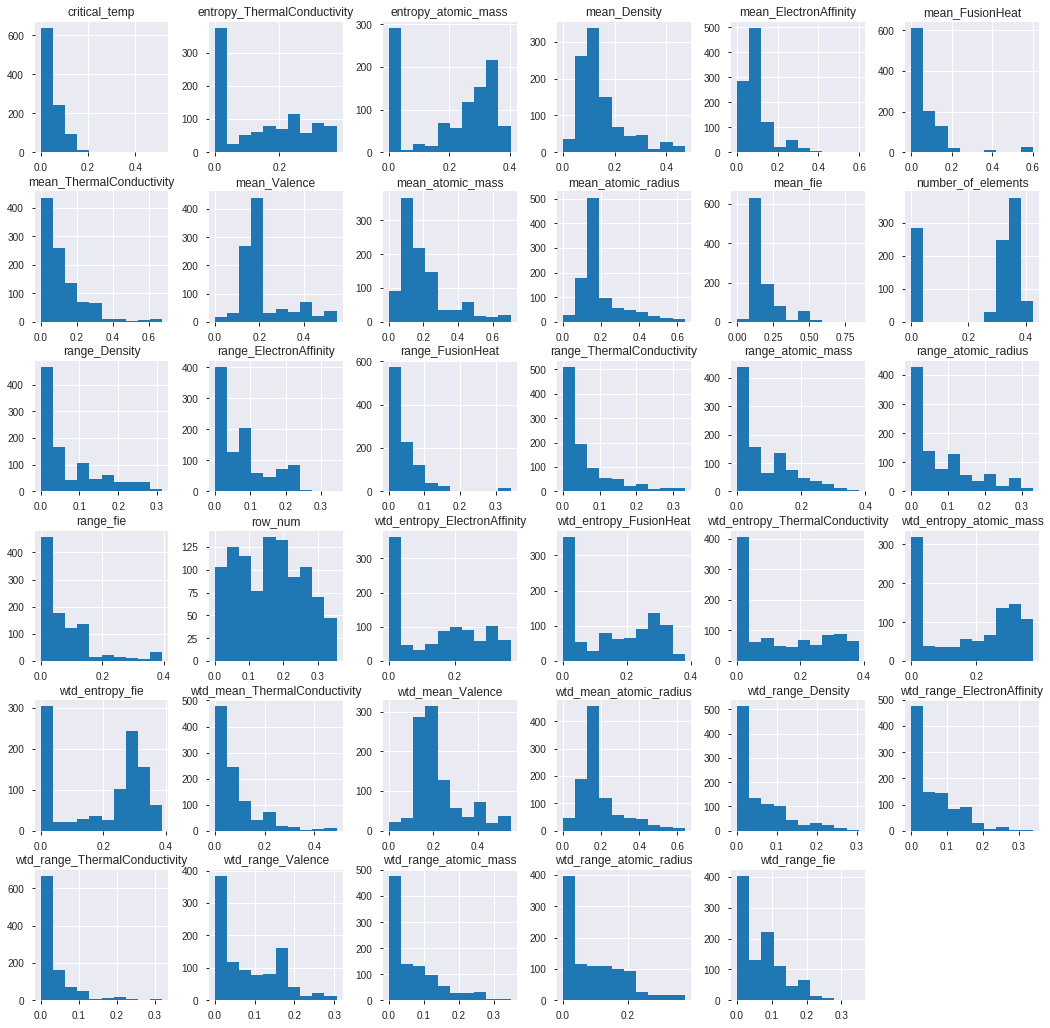

In [52]:
dataset.hist(figsize=(18, 18))
plt.show()

## Spot Checking Machine Learning Algorithms

In [0]:
# split features and labels
dataset_y = dataset['critical_temp']
dataset_X = dataset.drop(['critical_temp', 'row_num'], axis=1)

In [0]:
# train-test split
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, shuffle=True)

In [0]:
# spot-check ML algorithms
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

In [0]:
# create a dictionary of the candidate algorithms
ml_models = {
    'Linear Reg.': LinearRegression(),
    'Dec. Trees': DecisionTreeRegressor(),
    'Rand. Forest': RandomForestRegressor(),
    'SVM': SVR(),
    'XGBoost': XGBRegressor(),
    'NNets': MLPRegressor(warm_start=True, early_stopping=True, learning_rate='adaptive')
}

In [58]:
# for each algorithm, train with the training set and evaluate on the hold-out test set
ml_results = {}
for name, model in ml_models.items():
    # fit model on training data
    model.fit(X_train, y_train)
    # make predictions for test data
    prediction = model.predict(X_test)
    # evaluate predictions
    rmse = sqrt(mean_squared_error(y_test, prediction))
    # append accuracy results to dictionary
    ml_results[name] = rmse
    print('RMSE: {} -> {}'.format(name, rmse))

RMSE: Linear Reg. -> 0.052254350395023144
RMSE: Dec. Trees -> 0.023533410684730666
RMSE: Rand. Forest -> 0.02723603605511763
RMSE: SVM -> 0.07588484126991644
[14:41:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RMSE: XGBoost -> 0.028060770221813608
RMSE: NNets -> 0.04743655438333611


Text(0, 0.5, 'RMSE')

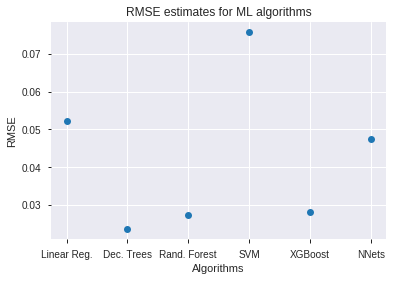

In [59]:
# plots of the model performances
plt.plot(ml_results.keys(), ml_results.values(), 'o')
plt.title("RMSE estimates for ML algorithms")
plt.xlabel('Algorithms')
plt.ylabel('RMSE')

## Dataflow and Tensorflow Transform for Large Scale Data Processing

### At this point, change the Notebook runtime type to Python 2.0

In [0]:
%%bash
source activate py2env
pip install --upgrade tensorflow
pip install --upgrade apache-beam[gcp]
pip install --upgrade tensorflow_transform==0.8.0
apt-get install libsnappy-dev
pip install --upgrade python-snappy==0.5.1

### Restart the kernel after you do a pip install

### Connect to GCP

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
# configure GCP project - change to your parameters
project_id = 'ekabasandbox'
bucket_name = 'ebisong-superconductor'
region = 'us-central1'
tf_version = '1.8'

In [3]:
!gcloud config set project {project_id}
!gcloud config set compute/region {region}

Updated property [core/project].
Updated property [compute/region].


### Create query method for retrieving training and testing datasets from BigQuery.

In [0]:
def create_query(phase, EVERY_N=None):
    """
    EVERY_N: Integer. Sample one out of every N rows from the full dataset. Larger values will yield smaller sample
    phase: 1=train 2=valid
    """
    base_query = """
    WITH super_df AS (
      SELECT
        number_of_elements, mean_atomic_mass, wtd_mean_atomic_mass,
        gmean_atomic_mass, wtd_gmean_atomic_mass, entropy_atomic_mass,
        wtd_entropy_atomic_mass, range_atomic_mass, wtd_range_atomic_mass,
        std_atomic_mass, wtd_std_atomic_mass, mean_fie, wtd_mean_fie,
        gmean_fie, wtd_gmean_fie, entropy_fie, wtd_entropy_fie, range_fie,
        wtd_range_fie, std_fie, wtd_std_fie, mean_atomic_radius, wtd_mean_atomic_radius,
        gmean_atomic_radius, wtd_gmean_atomic_radius, entropy_atomic_radius,
        wtd_entropy_atomic_radius, range_atomic_radius, wtd_range_atomic_radius,
        std_atomic_radius, wtd_std_atomic_radius, mean_Density, wtd_mean_Density,
        gmean_Density, wtd_gmean_Density, entropy_Density, wtd_entropy_Density,
        range_Density, wtd_range_Density, std_Density, wtd_std_Density, mean_ElectronAffinity,
        wtd_mean_ElectronAffinity, gmean_ElectronAffinity, wtd_gmean_ElectronAffinity
        entropy_ElectronAffinity, wtd_entropy_ElectronAffinity, range_ElectronAffinity,
        wtd_range_ElectronAffinity, std_ElectronAffinity, wtd_std_ElectronAffinity,
        mean_FusionHeat, wtd_mean_FusionHeat, gmean_FusionHeat, wtd_gmean_FusionHeat,
        entropy_FusionHeat, wtd_entropy_FusionHeat, range_FusionHeat,
        wtd_range_FusionHeat, std_FusionHeat, wtd_std_FusionHeat, mean_ThermalConductivity,
        wtd_mean_ThermalConductivity, gmean_ThermalConductivity, wtd_gmean_ThermalConductivity,
        entropy_ThermalConductivity, wtd_entropy_ThermalConductivity, range_ThermalConductivity,
        wtd_range_ThermalConductivity, std_ThermalConductivity, wtd_std_ThermalConductivity,
        mean_Valence, wtd_mean_Valence, gmean_Valence, wtd_gmean_Valence,
        entropy_Valence, wtd_entropy_Valence, range_Valence, wtd_range_Valence,
        std_Valence, wtd_std_Valence, critical_temp, ROW_NUMBER() OVER (PARTITION BY number_of_elements) row_num
      FROM
        `superconductor.superconductor`)
        
      SELECT
        * 
      FROM
        super_df
    """

    if EVERY_N == None:
        if phase < 2:
            # training
            query = "{0} WHERE MOD(row_num,4) < 2".format(base_query)
        else:
            query = "{0} WHERE MOD(row_num,4) = {1}".format(base_query, phase)
    else:
        query = "{0} WHERE MOD(row_num,{1}) = {2}".format(base_query, EVERY_N, phase)
    
    return query

Create requirements.txt file to install dependencies (in this case tensorflow_transform) on Dataflow worker machines.

In [5]:
%%writefile requirements.txt
tensorflow-transform==0.8.0

Overwriting requirements.txt


### Apache Beam to build a data preprocessing pipeline to transform the raw dataset into a form suitable for building a predictive model.

In [0]:
import datetime
import snappy
import tensorflow as tf
import apache_beam as beam
import tensorflow_transform as tft
from tensorflow_transform.beam import impl as beam_impl

def get_table_header(projection_fields):
    header = ''
    for cnt, val in enumerate(projection_fields):
        if cnt > 0:
            header+=','+val
        else:
            header+=val
    return header

def preprocess_tft(inputs):
    result = {}
    for attr, value in inputs.items():
        result[attr] = tft.scale_to_0_1(value)
      
    return result

def cleanup(rowdict):
    # pull columns from BQ and create a line
    CSV_COLUMNS = 'number_of_elements,mean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,mean_fie,wtd_mean_fie,wtd_entropy_fie,range_fie,wtd_range_fie,mean_atomic_radius,wtd_mean_atomic_radius,range_atomic_radius,wtd_range_atomic_radius,mean_Density,entropy_Density,wtd_entropy_Density,range_Density,wtd_range_Density,mean_ElectronAffinity,wtd_entropy_ElectronAffinity,range_ElectronAffinity,wtd_range_ElectronAffinity,mean_FusionHeat,gmean_FusionHeat,entropy_FusionHeat,wtd_entropy_FusionHeat,range_FusionHeat,wtd_range_FusionHeat,mean_ThermalConductivity,wtd_mean_ThermalConductivity,gmean_ThermalConductivity,entropy_ThermalConductivity,wtd_entropy_ThermalConductivity,range_ThermalConductivity,wtd_range_ThermalConductivity,mean_Valence,wtd_mean_Valence,range_Valence,wtd_range_Valence,wtd_std_Valence,critical_temp'.split(',')
    
    def tofloat(value, ifnot):
        try:
            return float(value)
        except (ValueError, TypeError):
            return ifnot

    result = {
      k : tofloat(rowdict[k], -99) if k in rowdict else -99 for k in CSV_COLUMNS
    }
    
    row = ('{}'+',{}'*(len(result)-1)).format(result['number_of_elements'],result['mean_atomic_mass'],
        result['entropy_atomic_mass'], result['wtd_entropy_atomic_mass'],result['range_atomic_mass'],
        result['wtd_range_atomic_mass'],result['mean_fie'],result['wtd_mean_fie'],
        result['wtd_entropy_fie'],result['range_fie'],result['wtd_range_fie'],
        result['mean_atomic_radius'],result['wtd_mean_atomic_radius'],
        result['range_atomic_radius'],result['wtd_range_atomic_radius'],result['mean_Density'],
        result['entropy_Density'],result['wtd_entropy_Density'],result['range_Density'],
        result['wtd_range_Density'],result['mean_ElectronAffinity'],
        result['wtd_entropy_ElectronAffinity'],result['range_ElectronAffinity'],
        result['wtd_range_ElectronAffinity'],result['mean_FusionHeat'],result['gmean_FusionHeat'],
        result['entropy_FusionHeat'],result['wtd_entropy_FusionHeat'],result['range_FusionHeat'],
        result['wtd_range_FusionHeat'],result['mean_ThermalConductivity'],
        result['wtd_mean_ThermalConductivity'],result['gmean_ThermalConductivity'],
        result['entropy_ThermalConductivity'],result['wtd_entropy_ThermalConductivity'],
        result['range_ThermalConductivity'],result['wtd_range_ThermalConductivity'],
        result['mean_Valence'],result['wtd_mean_Valence'],result['range_Valence'],
        result['wtd_range_Valence'],result['wtd_std_Valence'],result['critical_temp'])
    yield row
    
def preprocess():
    import os
    import os.path
    import datetime
    from apache_beam.io import WriteToText
    from apache_beam.io import tfrecordio
    from tensorflow_transform.coders import example_proto_coder
    from tensorflow_transform.tf_metadata import dataset_metadata
    from tensorflow_transform.tf_metadata import dataset_schema
    from tensorflow_transform.beam import tft_beam_io
    from tensorflow_transform.beam.tft_beam_io import transform_fn_io

    job_name = 'preprocess-features' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')
    
    print 'Launching Dataflow job {} ... hang on'.format(job_name)
    OUTPUT_DIR = 'gs://{0}/preproc_csv/'.format(bucket_name)
    import subprocess
    subprocess.call('gsutil rm -r {}'.format(OUTPUT_DIR).split())
    EVERY_N = 3
    
    options = {
      'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
      'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
      'job_name': job_name,
      'project': project_id,
      'max_num_workers': 24,
      'teardown_policy': 'TEARDOWN_ALWAYS',
      'no_save_main_session': True,
      'requirements_file': 'requirements.txt'
    }
    opts = beam.pipeline.PipelineOptions(flags=[], **options)
    RUNNER = 'DataflowRunner'

    # set up metadata
    raw_data_schema = {
      colname : dataset_schema.ColumnSchema(tf.float32, [], dataset_schema.FixedColumnRepresentation())
                      for colname in 'number_of_elements,mean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,mean_fie,wtd_mean_fie,wtd_entropy_fie,range_fie,wtd_range_fie,mean_atomic_radius,wtd_mean_atomic_radius,range_atomic_radius,wtd_range_atomic_radius,mean_Density,entropy_Density,wtd_entropy_Density,range_Density,wtd_range_Density,mean_ElectronAffinity,wtd_entropy_ElectronAffinity,range_ElectronAffinity,wtd_range_ElectronAffinity,mean_FusionHeat,gmean_FusionHeat,entropy_FusionHeat,wtd_entropy_FusionHeat,range_FusionHeat,wtd_range_FusionHeat,mean_ThermalConductivity,wtd_mean_ThermalConductivity,gmean_ThermalConductivity,entropy_ThermalConductivity,wtd_entropy_ThermalConductivity,range_ThermalConductivity,wtd_range_ThermalConductivity,mean_Valence,wtd_mean_Valence,range_Valence,wtd_range_Valence,wtd_std_Valence,critical_temp'.split(',')
    }
    raw_data_metadata = dataset_metadata.DatasetMetadata(dataset_schema.Schema(raw_data_schema))

    # run Beam  
    with beam.Pipeline(RUNNER, options=opts) as p:
        with beam_impl.Context(temp_dir=os.path.join(OUTPUT_DIR, 'tmp')):
            # save the raw data metadata
            _ = (raw_data_metadata
              | 'WriteInputMetadata' >> tft_beam_io.WriteMetadata(
                  os.path.join(OUTPUT_DIR, 'metadata/rawdata_metadata'),
                  pipeline=p))

            projection_fields = ['number_of_elements', 'mean_atomic_mass', 'entropy_atomic_mass',
                                 'wtd_entropy_atomic_mass', 'range_atomic_mass',
                                 'wtd_range_atomic_mass', 'mean_fie', 'wtd_mean_fie',
                                 'wtd_entropy_fie', 'range_fie', 'wtd_range_fie',
                                 'mean_atomic_radius', 'wtd_mean_atomic_radius',
                                 'range_atomic_radius', 'wtd_range_atomic_radius', 'mean_Density',
                                 'entropy_Density', 'wtd_entropy_Density', 'range_Density',
                                 'wtd_range_Density', 'mean_ElectronAffinity',
                                 'wtd_entropy_ElectronAffinity', 'range_ElectronAffinity',
                                 'wtd_range_ElectronAffinity', 'mean_FusionHeat', 'gmean_FusionHeat',
                                 'entropy_FusionHeat', 'wtd_entropy_FusionHeat', 'range_FusionHeat',
                                 'wtd_range_FusionHeat', 'mean_ThermalConductivity',
                                 'wtd_mean_ThermalConductivity', 'gmean_ThermalConductivity',
                                 'entropy_ThermalConductivity', 'wtd_entropy_ThermalConductivity',
                                 'range_ThermalConductivity', 'wtd_range_ThermalConductivity',
                                 'mean_Valence', 'wtd_mean_Valence', 'range_Valence',
                                 'wtd_range_Valence', 'wtd_std_Valence', 'critical_temp']
            header = get_table_header(projection_fields)

            # analyze and transform training       
            raw_data = (p 
              | 'train_read' >> beam.io.Read(beam.io.BigQuerySource(query=create_query(1, EVERY_N), use_standard_sql=True)))

            raw_dataset = (raw_data, raw_data_metadata)
            transformed_dataset, transform_fn = (
                raw_dataset | beam_impl.AnalyzeAndTransformDataset(preprocess_tft))
            transformed_data, transformed_metadata = transformed_dataset

            _ = (transformed_data
                 | 'train_filter' >> beam.FlatMap(cleanup)
                 | 'WriteTrainData' >> beam.io.Write(beam.io.WriteToText(
                      file_path_prefix=os.path.join(OUTPUT_DIR, 'data', 'train'),
                      file_name_suffix=".csv",
                      shard_name_template="-SS-of-NN",
                      header=header,
                      num_shards=1)))

            # transform eval data
            raw_test_data = (p 
              | 'eval_read' >> beam.io.Read(beam.io.BigQuerySource(query=create_query(2, EVERY_N), use_standard_sql=True)))

            raw_test_dataset = (raw_test_data, raw_data_metadata)
            transformed_test_dataset = (
                (raw_test_dataset, transform_fn) | beam_impl.TransformDataset())
            transformed_test_data, _ = transformed_test_dataset

            _ = (transformed_test_data
                 | 'eval_filter' >> beam.FlatMap(cleanup)
                 | 'WriteTestData' >> beam.io.Write(beam.io.WriteToText(
                        file_path_prefix=os.path.join(OUTPUT_DIR, 'data', 'eval'),
                        file_name_suffix=".csv",
                        shard_name_template="-SS-of-NN",
                        num_shards=1)))

            _ = (transform_fn
                 | 'WriteTransformFn' >>
                 transform_fn_io.WriteTransformFn(os.path.join(OUTPUT_DIR, 'metadata')))

preprocess()

## Training on Cloud MLE

### At this point, change the Notebook runtime type to Python 3.0

In [0]:
# configure GCP project - change to your parameters
project_id = 'ekabasandbox'
bucket_name = 'ebisong-superconductor'
region = 'us-central1'
tf_version = '1.8'

In [0]:
import os
os.environ['bucket_name'] = bucket_name
os.environ['tf_version'] = tf_version
os.environ['project_id'] = project_id
os.environ['region'] = region

### Training Source Files

In [3]:
# create directory trainer
import os
try:
    os.makedirs('./trainer')
    print('directory created')
except OSError:
    print('could not create directory')

directory created


In [4]:
%%writefile trainer/__init__.py
 

Writing trainer/__init__.py


In [14]:
# update the bucket names in this file.
%%writefile trainer/task.py
import argparse
import json
import os

import tensorflow as tf
from tensorflow.contrib.training.python.training import hparam

import trainer.model as model

def _get_session_config_from_env_var():
    """Returns a tf.ConfigProto instance that has appropriate device_filters set.
    """

    tf_config = json.loads(os.environ.get('TF_CONFIG', '{}'))

    if (tf_config and 'task' in tf_config and 'type' in tf_config['task'] and
       'index' in tf_config['task']):
        # Master should only communicate with itself and ps
        if tf_config['task']['type'] == 'master':
            return tf.ConfigProto(device_filters=['/job:ps', '/job:master'])
        # Worker should only communicate with itself and ps
        elif tf_config['task']['type'] == 'worker':
            return tf.ConfigProto(device_filters=[
                '/job:ps',
                '/job:worker/task:%d' % tf_config['task']['index']
            ])
    return None
  
def train_and_evaluate(hparams):
    """Run the training and evaluate using the high level API."""

    train_input = lambda: model.input_fn(
        tf.gfile.Glob(hparams.train_files),
        num_epochs=hparams.num_epochs,
        batch_size=hparams.train_batch_size
    )

    # Don't shuffle evaluation data
    eval_input = lambda: model.input_fn(
        tf.gfile.Glob(hparams.eval_files),
        batch_size=hparams.eval_batch_size,
        shuffle=False
    )

    train_spec = tf.estimator.TrainSpec(
        train_input, max_steps=hparams.train_steps)

    exporter = tf.estimator.FinalExporter(
        'superconductor', model.SERVING_FUNCTIONS[hparams.export_format])
    eval_spec = tf.estimator.EvalSpec(
        eval_input,
        steps=hparams.eval_steps,
        exporters=[exporter],
        name='superconductor-eval')

    run_config = tf.estimator.RunConfig(
        session_config=_get_session_config_from_env_var())
    run_config = run_config.replace(model_dir=hparams.job_dir)
    print('Model dir %s' % run_config.model_dir)
    estimator = model.build_estimator(
        learning_rate=hparams.learning_rate,
        # Construct layers sizes with exponential decay
        hidden_units=[
            max(2, int(hparams.first_layer_size * hparams.scale_factor**i))
            for i in range(hparams.num_layers)
        ],
        config=run_config,
        output_dir=hparams.output_dir)

    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    # Input Arguments
    parser.add_argument(
        '--train-files',
        help='GCS file or local paths to training data',
        nargs='+',
        # update the bucket name
        default='gs://{}/preproc_csv/data/{}*{}*'.format('ebisong-superconductor', tf.estimator.ModeKeys.TRAIN, 'of'))
    parser.add_argument(
        '--eval-files',
        help='GCS file or local paths to evaluation data',
        nargs='+',
        # update the bucket name
        default='gs://{}/preproc_csv/data/{}*{}*'.format('ebisong-superconductor', tf.estimator.ModeKeys.EVAL, 'of'))
    parser.add_argument(
        '--job-dir',
        help='GCS location to write checkpoints and export models',
        default='/tmp/superconductor-estimator')
    parser.add_argument(
        '--num-epochs',
        help="""\
        Maximum number of training data epochs on which to train.
        If both --max-steps and --num-epochs are specified,
        the training job will run for --max-steps or --num-epochs,
        whichever occurs first. If unspecified will run for --max-steps.\
        """,
        type=int)
    parser.add_argument(
        '--train-batch-size',
        help='Batch size for training steps',
        type=int,
        default=20)
    parser.add_argument(
        '--eval-batch-size',
        help='Batch size for evaluation steps',
        type=int,
        default=20)
    parser.add_argument(
        '--learning-rate',
        help='The training learning rate',
        default=1e-4,
        type=float)
    parser.add_argument(
        '--first-layer-size',
        help='Number of nodes in the first layer of the DNN',
        default=256,
        type=int)
    parser.add_argument(
        '--num-layers', help='Number of layers in the DNN', default=3, type=int)
    parser.add_argument(
        '--scale-factor',
        help='How quickly should the size of the layers in the DNN decay',
        default=0.7,
        type=float)
    parser.add_argument(
        '--train-steps',
        help="""\
        Steps to run the training job for. If --num-epochs is not specified,
        this must be. Otherwise the training job will run indefinitely.\
        """,
        default=100,
        type=int)
    parser.add_argument(
        '--eval-steps',
        help='Number of steps to run evalution for at each checkpoint',
        default=100,
        type=int)
    parser.add_argument(
        '--export-format',
        help='The input format of the exported SavedModel binary',
        choices=['JSON', 'CSV', 'EXAMPLE'],
        default='CSV')
    parser.add_argument(
        '--output-dir',
        help='Location of the exported model',
        nargs='+')
    parser.add_argument(
        '--verbosity',
        choices=['DEBUG', 'ERROR', 'FATAL', 'INFO', 'WARN'],
        default='INFO')

    args, _ = parser.parse_known_args()

    # Set python level verbosity
    tf.logging.set_verbosity(args.verbosity)
    # Set C++ Graph Execution level verbosity
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = str(
        tf.logging.__dict__[args.verbosity] / 10)

    # Run the training job
    hparams = hparam.HParams(**args.__dict__)
    train_and_evaluate(hparams)

Overwriting trainer/task.py


In [6]:
%%writefile trainer/model.py
import six

import tensorflow as tf
from tensorflow.python.estimator.model_fn import ModeKeys as Modes

# Define the format of your input data including unused columns.
CSV_COLUMNS = [
    'number_of_elements', 'mean_atomic_mass', 'entropy_atomic_mass',
   'wtd_entropy_atomic_mass', 'range_atomic_mass',
   'wtd_range_atomic_mass', 'mean_fie', 'wtd_mean_fie',
   'wtd_entropy_fie', 'range_fie', 'wtd_range_fie',
   'mean_atomic_radius', 'wtd_mean_atomic_radius',
   'range_atomic_radius', 'wtd_range_atomic_radius', 'mean_Density',
   'entropy_Density', 'wtd_entropy_Density', 'range_Density',
   'wtd_range_Density', 'mean_ElectronAffinity',
   'wtd_entropy_ElectronAffinity', 'range_ElectronAffinity',
   'wtd_range_ElectronAffinity', 'mean_FusionHeat', 'gmean_FusionHeat',
   'entropy_FusionHeat', 'wtd_entropy_FusionHeat', 'range_FusionHeat',
   'wtd_range_FusionHeat', 'mean_ThermalConductivity',
   'wtd_mean_ThermalConductivity', 'gmean_ThermalConductivity',
   'entropy_ThermalConductivity', 'wtd_entropy_ThermalConductivity',
   'range_ThermalConductivity', 'wtd_range_ThermalConductivity',
   'mean_Valence', 'wtd_mean_Valence', 'range_Valence',
   'wtd_range_Valence', 'wtd_std_Valence', 'critical_temp'
]

CSV_COLUMN_DEFAULTS = [[0.0] for i in range(0, len(CSV_COLUMNS))]
LABEL_COLUMN = 'critical_temp'

# Define the initial ingestion of each feature used by your model.
# Additionally, provide metadata about the feature.
INPUT_COLUMNS = [tf.feature_column.numeric_column(i) for i in CSV_COLUMNS[:-1]]

UNUSED_COLUMNS = set(CSV_COLUMNS) - {col.name for col in INPUT_COLUMNS} - \
    {LABEL_COLUMN}

def build_estimator(config, output_dir, hidden_units=None, learning_rate=None):
    """
    Deep NN Regression model.
    Args:
        config: (tf.contrib.learn.RunConfig) defining the runtime environment for
          the estimator (including model_dir).
        hidden_units: [int], the layer sizes of the DNN (input layer first)
        learning_rate: (int), the learning rate for the optimizer.
    Returns:
        A DNNRegressor
    """
    (number_of_elements,mean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass, \
      range_atomic_mass,wtd_range_atomic_mass,mean_fie,wtd_mean_fie,wtd_entropy_fie,range_fie,\
      wtd_range_fie,mean_atomic_radius,wtd_mean_atomic_radius,range_atomic_radius,wtd_range_atomic_radius,\
      mean_Density,entropy_Density,wtd_entropy_Density,range_Density,wtd_range_Density,mean_ElectronAffinity,\
      wtd_entropy_ElectronAffinity,range_ElectronAffinity,wtd_range_ElectronAffinity,mean_FusionHeat,\
      gmean_FusionHeat,entropy_FusionHeat,wtd_entropy_FusionHeat,range_FusionHeat,wtd_range_FusionHeat,\
      mean_ThermalConductivity,wtd_mean_ThermalConductivity,gmean_ThermalConductivity,entropy_ThermalConductivity,\
      wtd_entropy_ThermalConductivity,range_ThermalConductivity,wtd_range_ThermalConductivity,mean_Valence,\
      wtd_mean_Valence,range_Valence,wtd_range_Valence,wtd_std_Valence) = INPUT_COLUMNS
    
    columns = [number_of_elements,mean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass, \
      range_atomic_mass,wtd_range_atomic_mass,mean_fie,wtd_mean_fie,wtd_entropy_fie,range_fie,\
      wtd_range_fie,mean_atomic_radius,wtd_mean_atomic_radius,range_atomic_radius,wtd_range_atomic_radius,\
      mean_Density,entropy_Density,wtd_entropy_Density,range_Density,wtd_range_Density,mean_ElectronAffinity,\
      wtd_entropy_ElectronAffinity,range_ElectronAffinity,wtd_range_ElectronAffinity,mean_FusionHeat,\
      gmean_FusionHeat,entropy_FusionHeat,wtd_entropy_FusionHeat,range_FusionHeat,wtd_range_FusionHeat,\
      mean_ThermalConductivity,wtd_mean_ThermalConductivity,gmean_ThermalConductivity,entropy_ThermalConductivity,\
      wtd_entropy_ThermalConductivity,range_ThermalConductivity,wtd_range_ThermalConductivity,mean_Valence,\
      wtd_mean_Valence,range_Valence,wtd_range_Valence,wtd_std_Valence]

    estimator = tf.estimator.DNNRegressor(
      model_dir=output_dir,
      config=config,
      feature_columns=columns,
      hidden_units=hidden_units or [256, 128, 64],
      optimizer=tf.train.AdamOptimizer(learning_rate)
    )
    
    # add extra evaluation metric for hyperparameter tuning
    estimator = tf.contrib.estimator.add_metrics(estimator, add_eval_metrics)
    return estimator

def add_eval_metrics(labels, predictions):
    pred_values = predictions['predictions']
    return {
        'rmse': tf.metrics.root_mean_squared_error(labels, pred_values)
    }

# [START serving-function]
  
def csv_serving_input_fn():
    """Build the serving inputs."""
    csv_row = tf.placeholder(shape=[None], dtype=tf.string)
    features = _decode_csv(csv_row)
    # Ignore label column
    features.pop(LABEL_COLUMN)
    return tf.estimator.export.ServingInputReceiver(features,
                                              {'csv_row': csv_row})

def example_serving_input_fn():
    """Build the serving inputs."""
    example_bytestring = tf.placeholder(
      shape=[None],
      dtype=tf.string,
    )
    features = tf.parse_example(
      example_bytestring,
      tf.feature_column.make_parse_example_spec(INPUT_COLUMNS))
    return tf.estimator.export.ServingInputReceiver(
      features, {'example_proto': example_bytestring})

def json_serving_input_fn():
    """Build the serving inputs."""
    inputs = {}
    for feat in INPUT_COLUMNS:
        inputs[feat.name] = tf.placeholder(shape=[None], dtype=feat.dtype)

    return tf.estimator.export.ServingInputReceiver(inputs, inputs)

# [END serving-function]

SERVING_FUNCTIONS = {
  'JSON': json_serving_input_fn,
  'EXAMPLE': example_serving_input_fn,
  'CSV': csv_serving_input_fn
}

def _decode_csv(line):
    """Takes the string input tensor and returns a dict of rank-2 tensors."""

    # Takes a rank-1 tensor and converts it into rank-2 tensor
    row_columns = tf.expand_dims(line, -1)
    columns = tf.decode_csv(row_columns, record_defaults=CSV_COLUMN_DEFAULTS)
    features = dict(zip(CSV_COLUMNS, columns))

    # Remove unused columns
    for col in UNUSED_COLUMNS:
        features.pop(col)
    return features

def input_fn(filenames, num_epochs=None, shuffle=True, skip_header_lines=1, batch_size=200):
    """Generates features and labels for training or evaluation.
    This uses the input pipeline based approach using file name queue
    to read data so that entire data is not loaded in memory.
    Args:
      filenames: [str] A List of CSV file(s) to read data from.
      num_epochs: (int) how many times through to read the data. If None will
        loop through data indefinitely
      shuffle: (bool) whether or not to randomize the order of data. Controls
        randomization of both file order and line order within files.
      skip_header_lines: (int) set to non-zero in order to skip header lines in
        CSV files.
      batch_size: (int) First dimension size of the Tensors returned by input_fn
    Returns:
      A (features, indices) tuple where features is a dictionary of
        Tensors, and indices is a single Tensor of label indices.
    """
    dataset = tf.data.TextLineDataset(filenames).skip(skip_header_lines).map(
      _decode_csv)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 10)
    iterator = dataset.repeat(num_epochs).batch(
        batch_size).make_one_shot_iterator()
    features = iterator.get_next()
    return features, features.pop(LABEL_COLUMN)

Writing trainer/model.py


In [7]:
%%writefile hptuning_config.yaml
trainingInput:
  hyperparameters:
    hyperparameterMetricTag: rmse
    goal: MINIMIZE
    maxTrials: 4 #20
    maxParallelTrials: 2 #5
    enableTrialEarlyStopping: True
    algorithm: RANDOM_SEARCH
    params:
      - parameterName: learning-rate
        type: DOUBLE
        minValue: 0.00001
        maxValue: 0.005
        scaleType: UNIT_LOG_SCALE
      - parameterName: first-layer-size
        type: INTEGER
        minValue: 50
        maxValue: 500
        scaleType: UNIT_LINEAR_SCALE
      - parameterName: num-layers
        type: INTEGER
        minValue: 1
        maxValue: 15
        scaleType: UNIT_LINEAR_SCALE
      - parameterName: scale-factor
        type: DOUBLE
        minValue: 0.1
        maxValue: 1.0
        scaleType: UNIT_REVERSE_LOG_SCALE

Writing hptuning_config.yaml


### Train distributed

In [15]:
%%bash
# run training job
JOB_NAME=superconductor_$(date -u +%y%m%d_%H%M%S)
HPTUNING_CONFIG=hptuning_config.yaml
GCS_JOB_DIR=gs://$bucket_name/jobs/$JOB_NAME

echo $GCS_JOB_DIR

gcloud ai-platform jobs submit training $JOB_NAME \
                                    --stream-logs \
                                    --runtime-version $tf_version \
                                    --job-dir $GCS_JOB_DIR \
                                    --module-name trainer.task \
                                    --package-path trainer/ \
                                    --region us-central1 \
                                    --scale-tier=STANDARD_1 \
                                    --config $HPTUNING_CONFIG \
                                    -- \
                                    --train-steps 5000 \
                                    --eval-steps 100

gs://ebisong-superconductor/jobs/superconductor_190715_121616
endTime: '2019-07-15T12:24:01'
jobId: superconductor_190715_121616
startTime: '2019-07-15T12:16:22'
state: SUCCEEDED


Job [superconductor_190715_121616] submitted successfully.
INFO	2019-07-15 12:16:19 +0000	service		Validating job requirements...
INFO	2019-07-15 12:16:19 +0000	service		Job creation request has been successfully validated.
INFO	2019-07-15 12:16:19 +0000	service		Job superconductor_190715_121616 is queued.
INFO	2019-07-15 12:16:28 +0000	service	1	Waiting for job to be provisioned.
INFO	2019-07-15 12:16:28 +0000	service	2	Waiting for job to be provisioned.
INFO	2019-07-15 12:16:28 +0000	service	1	Waiting for training program to start.
INFO	2019-07-15 12:16:28 +0000	service	2	Waiting for training program to start.
INFO	2019-07-15 12:16:37 +0000	ps-replica-0	1	Running task with arguments: --cluster={"master": ["cmle-training-master-106d9c65d6-0:2222"], "ps": ["cmle-training-ps-106d9c65d6-0:2222", "cmle-training-ps-106d9c65d6-1:2222", "cmle-training-ps-106d9c65d6-2:2222"], "worker": ["cmle-training-worker-106d9c65d6-0:2222", "cmle-training-worker-106d9c65d6-1:2222", "cmle-training-worker-1

### Deploy Trained Model

In [16]:
# Display content of selected trained model directory.
%%bash
gsutil ls gs://$bucket_name/jobs/superconductor_190715_121616/3/export/superconductor/1563193269/

gs://ebisong-superconductor/jobs/superconductor_190715_121616/3/export/superconductor/1563193269/
gs://ebisong-superconductor/jobs/superconductor_190715_121616/3/export/superconductor/1563193269/saved_model.pb
gs://ebisong-superconductor/jobs/superconductor_190715_121616/3/export/superconductor/1563193269/variables/


In [17]:
# Deploy the model.
%%bash
MODEL_NAME="superconductor"
MODEL_VERSION="v1"
MODEL_LOCATION=gs://$bucket_name/jobs/superconductor_190715_121616/3/export/superconductor/1563193269/

echo "Deploying model $MODEL_NAME $MODEL_VERSION"
gcloud ai-platform models create ${MODEL_NAME} --regions us-central1
gcloud ai-platform versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version ${tf_version}

Deploying model superconductor v1


Created ml engine model [projects/ekabasandbox/models/superconductor].
Creating version (this might take a few minutes)......
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### Batch Prediction

In [0]:
%%bash
JOB_NAME=superconductor_prediction
MODEL_NAME=superconductor
MODEL_VERSION=v1
TEST_FILE=gs://$bucket_name/preproc_csv/data/eval-00-of-01.csv
OUTPUT_DIR=gs://$bucket_name/jobs/$JOB_NAME/predictions

echo $OUTPUT_DIR

# submit a batched job
gcloud ai-platform jobs submit prediction $JOB_NAME \
        --model $MODEL_NAME \
        --version $MODEL_VERSION \
        --data-format TEXT \
        --region $region \
        --input-paths $TEST_FILE \
        --output-path $OUTPUT_DIR

# stream job logs
echo "Job logs..."
gcloud ai-platform jobs stream-logs $JOB_NAME

In [25]:
# List the contents of the prediction output directory in GCS.
%%bash
gsutil ls gs://$bucket_name/jobs/superconductor_prediction/predictions/

gs://ebisong-superconductor/jobs/superconductor_prediction/predictions/prediction.errors_stats-00000-of-00001
gs://ebisong-superconductor/jobs/superconductor_prediction/predictions/prediction.results-00000-of-00002
gs://ebisong-superconductor/jobs/superconductor_prediction/predictions/prediction.results-00001-of-00002


In [26]:
#	Show predicted RMSE outputs.
%%bash
# read output summary
echo "Job output summary:"
gsutil cat 'gs://ebisong-superconductor/jobs/superconductor_prediction/predictions/prediction.results-00000-of-00002'

Job output summary:
{"outputs": [0.43752962350845337]}
{"outputs": [0.6859142780303955]}
{"outputs": [0.6435124278068542]}
{"outputs": [0.4579634666442871]}
{"outputs": [0.4457523226737976]}
{"outputs": [0.45652657747268677]}
{"outputs": [0.485465407371521]}
{"outputs": [0.16270555555820465]}
{"outputs": [0.4460254907608032]}
{"outputs": [0.4294111132621765]}
{"outputs": [0.4292380213737488]}
{"outputs": [0.15650056302547455]}
{"outputs": [0.07685323804616928]}
{"outputs": [0.17239174246788025]}
{"outputs": [0.5229272842407227]}
{"outputs": [0.13428521156311035]}
{"outputs": [0.1426830291748047]}
{"outputs": [0.4813729226589203]}
{"outputs": [0.40794697403907776]}
{"outputs": [0.420121967792511]}
{"outputs": [0.23552992939949036]}
{"outputs": [0.2748851478099823]}
{"outputs": [0.1975434124469757]}
{"outputs": [0.37228983640670776]}
{"outputs": [0.5007217526435852]}
{"outputs": [0.7156890630722046]}
{"outputs": [0.3754136562347412]}
{"outputs": [0.2123483121395111]}
{"outputs": [0.36613